## Keras denoising autoencoder

Modified version from keras example: https://github.com/keras-team/keras/blob/master/examples/mnist_denoising_autoencoder.py

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import keras
from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model, load_model
from keras import backend as K
from keras.datasets import mnist
from keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import mlflow

Using TensorFlow backend.


In [2]:
import datetime
import platform

from os.path import expanduser
from os import path
import logging

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn_evaluation import plot as sk_plot

import yass
from yass import read_config, preprocess, detect
from yass import util as yass_util
from yass.augment import make, util
from yass.augment.noise import noise_cov
from yass.neuralnetwork import evaluate
from yass.explore import RecordingExplorer, SpikeTrainExplorer

import numpy as np
from scipy.io import loadmat

from dstools import plot, reproducibility

# logging.basicConfig(level=logging.DEBUG)

In [3]:
print('Running YASS version: '+yass_util.get_version())

Running YASS version: 3fdca03 Adds cat's preprocess and detect implementations (#267)


In [4]:
yass.set_config("../config/gcloud/49/default.yaml", 'tmp')

CONFIG = read_config()

In [5]:
path_to_data = path.expanduser('~/data/retinal')
path_to_ground_truth = path.join(path_to_data,
                                 'groundtruth_ej49_data1_set1.mat')
path_to_experiment = path.join(path_to_data, 'sample_output')
path_to_standarized = path.join(path_to_experiment,
                                'preprocess', 'standarized.bin')
path_to_geom = path.join(path_to_data, 'ej49_geometry1.txt')
path_to_here = path.expanduser('~/dev/private-yass/nnet')

In [6]:
def filename(extension=None):
    """Generate a valid directory name with the current datetime
    """
    now = datetime.datetime.now()
    name =  now.strftime('%d-%b-%Y@%H-%M-%S')
    
    if extension is not None:
        name += '.'+extension
    
    return name

In [7]:
templates = np.load('/home/Edu/data/cat/templates-jul27-only-good.npy')

In [8]:
templates.shape[2]

49

In [9]:
from yass.batch import RecordingsReader

rec = RecordingsReader(path_to_standarized, loader='array').data

In [10]:
(spatial_sig,
 temporal_sig) = noise_cov(rec, templates.shape[1], templates.shape[1])

In [11]:
min_amplitude = 5
max_amplitude = 15
n_clean_per_template = 30

dataset = evaluate.Dataset.make(10, True, templates,
                                 min_amplitude, max_amplitude,
                                 n_clean_per_template,
                                 spatial_sig, temporal_sig,
                                 0)

In [12]:
dataset.stats

{'from templates': 7200,
 'spatially misaligned': 7200,
 'temporally misaligned': 7200,
 'collided': 7200,
 'noise': 7200}

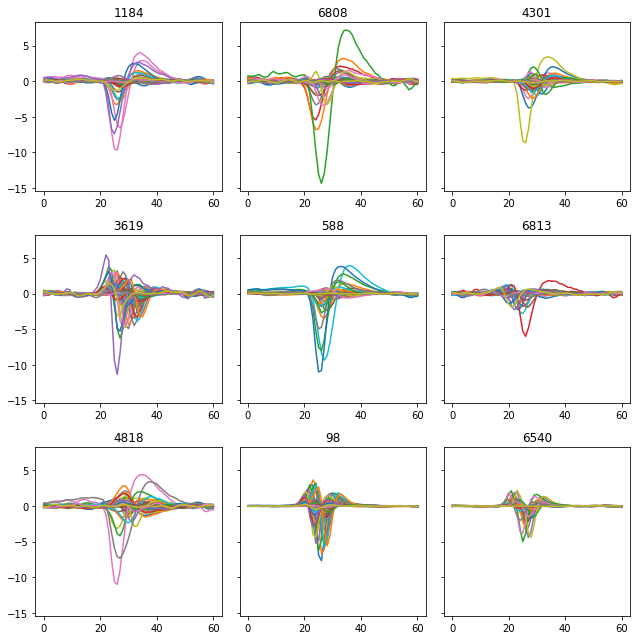

In [13]:
plot.grid_from_array(dataset.get_kind('from templates').data_clean,
                     axis=0, elements=9,
                     auto_figsize=3, sharey=True)

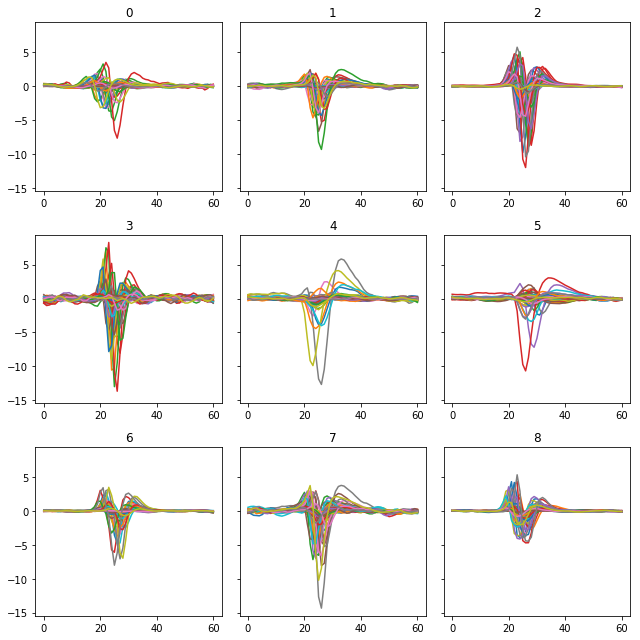

In [14]:
plot.grid_from_array(dataset.get_kind('spatially misaligned').data_clean,
                     axis=0, elements=range(9),
                     auto_figsize=3, sharey=True)

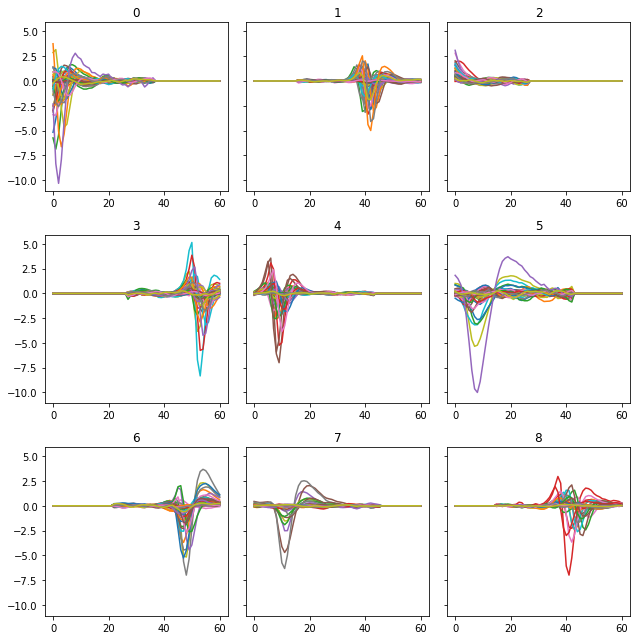

In [15]:
plot.grid_from_array(dataset.get_kind('temporally misaligned').data_clean,
                     axis=0, elements=range(9),
                     auto_figsize=3, sharey=True)

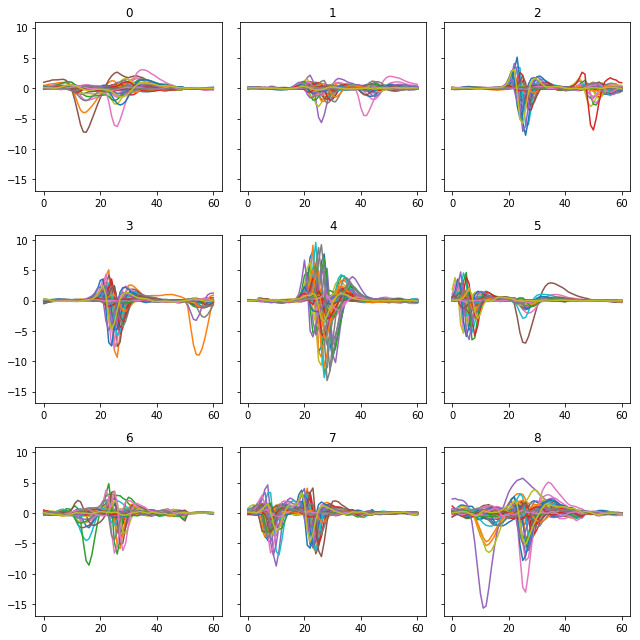

In [16]:
plot.grid_from_array(dataset.get_kind('collided').data_clean,
                     axis=0, elements=range(9),
                     auto_figsize=3, sharey=True)

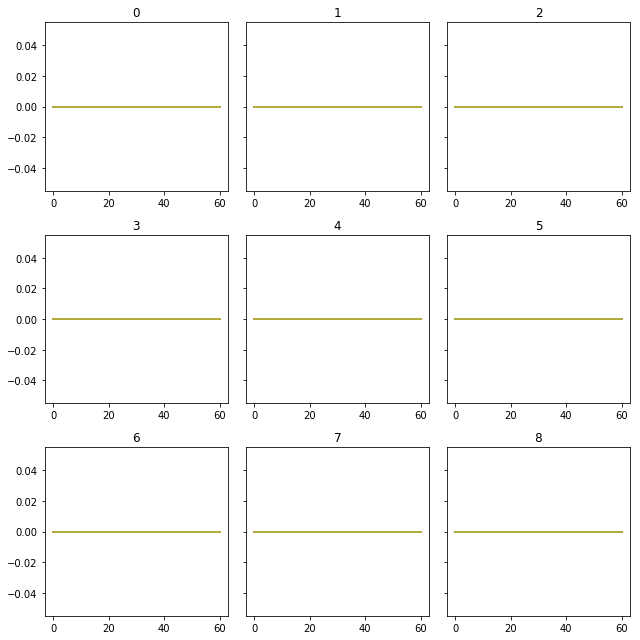

In [17]:
plot.grid_from_array(dataset.get_kind('noise').data_clean,
                     axis=0, elements=range(9),
                     auto_figsize=3, sharey=True)

## Generating train and test sets

In [18]:
data_noisy = dataset.data
data_clean = dataset.data_clean

(x_train_noisy,
 x_train_clean,
 x_test_noisy,
 x_test_clean) = evaluate.split(data_noisy, data_clean,
                                train_proportion=0.7)

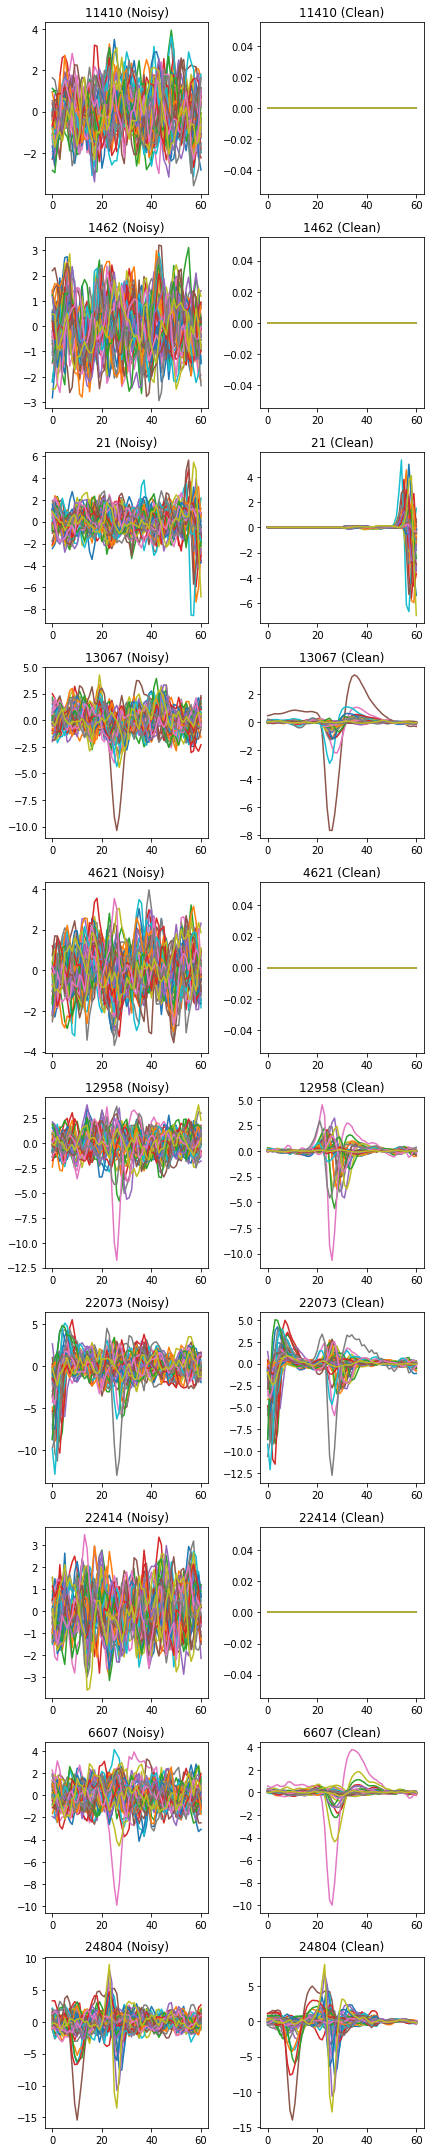

In [19]:
plot.grid_from_array([x_train_noisy, x_train_clean],
                     axis=0,
                     elements=10,
                     group_names=('Noisy', 'Clean'),
                     auto_figsize=3)

## PCA

In [20]:
x_train_noisy.shape

(25200, 61, 49)

In [21]:
from sklearn.decomposition import PCA

pca = PCA(0.40).fit(x_train_noisy.reshape((len(x_train_noisy), -1)))
pca.n_components_

101

In [22]:
components = pca.transform(x_test_noisy.reshape((len(x_test_noisy), -1)))
x_test_denoised_pca = pca.inverse_transform(components).reshape(x_test_noisy.shape)

In [23]:
residual_pca = x_test_clean - x_test_denoised_pca

In [24]:
np.mean(residual_pca ** 2)

0.6057107726539495

In [25]:
# worst we can do...
np.mean((x_test_clean - x_test_noisy) ** 2)

1.0960396038551714

In [26]:
selected = np.random.randint(x_test_noisy.shape[0], size=10)

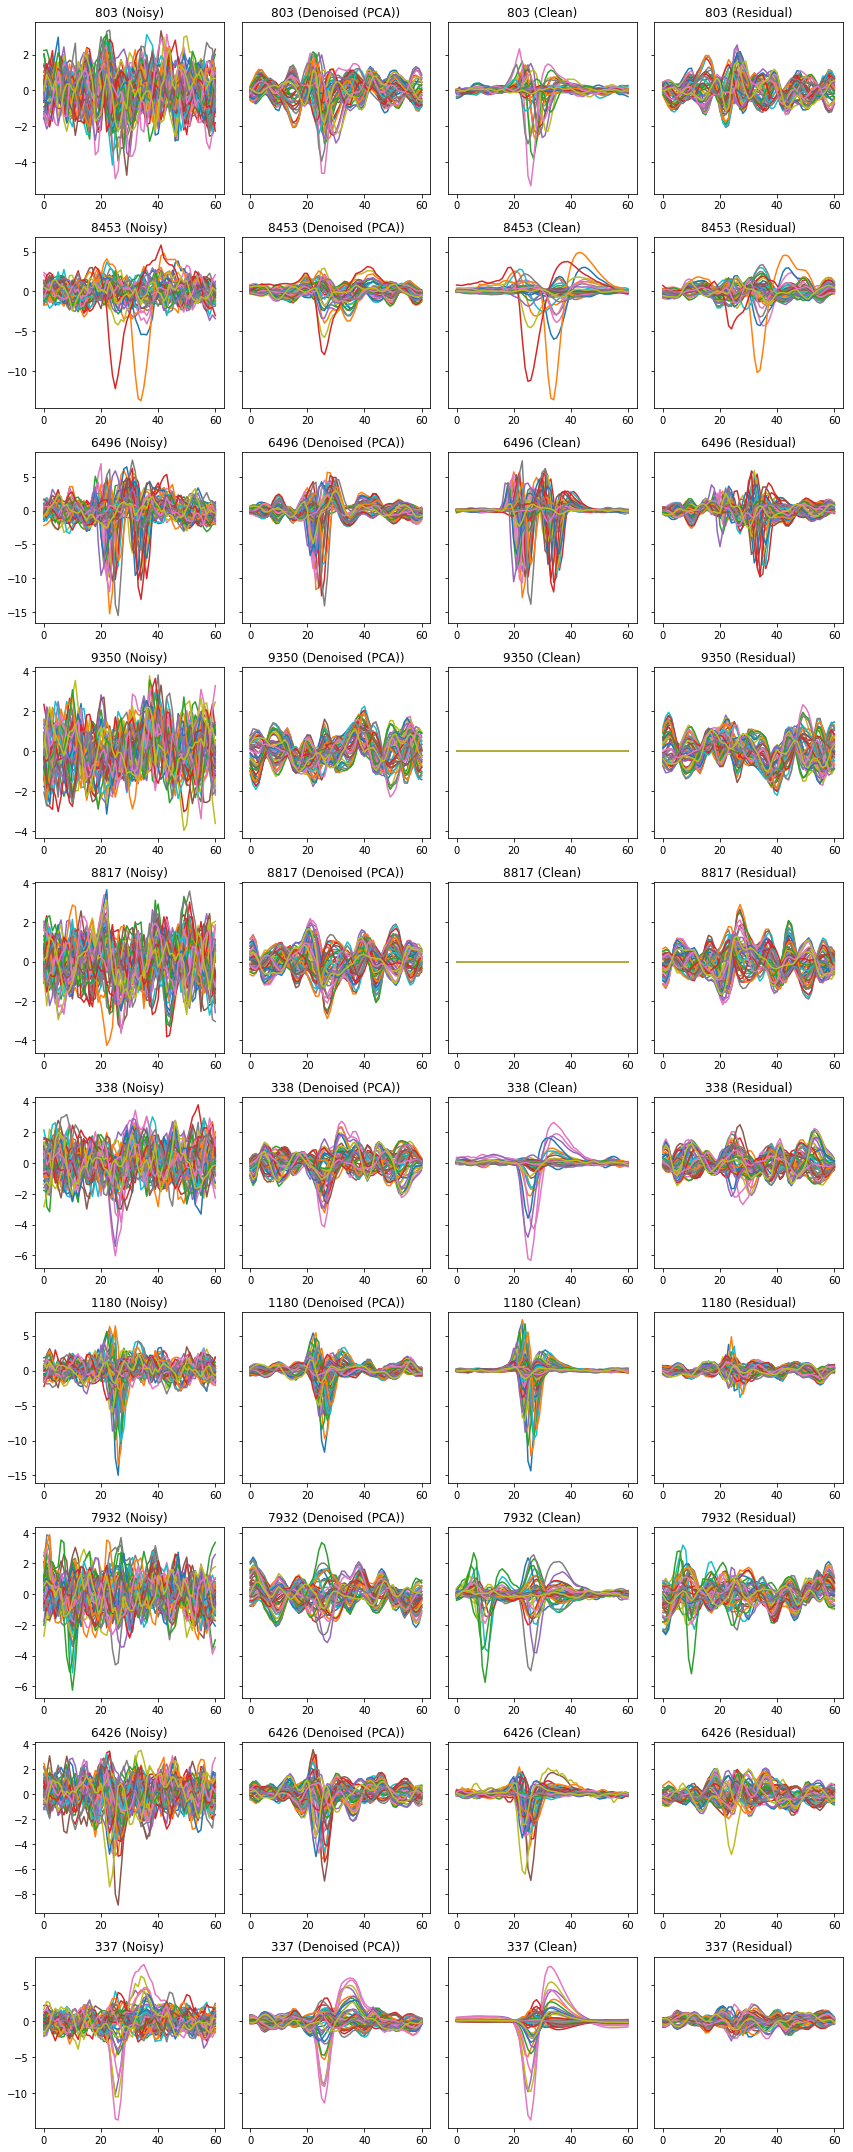

In [27]:
plot.grid_from_array([x_test_noisy,
                      x_test_denoised_pca,
                      x_test_clean,
                     residual_pca],
                     axis=0,
                     group_names=('Noisy', 'Denoised (PCA)', 'Clean', 'Residual'),
                     elements=selected,
                     auto_figsize=3,
                     sharey='row')

In [29]:
n_spikes, waveform_length, n_neighbors = x_train_clean.shape

# Network parameters
input_shape = (waveform_length, n_neighbors, 1)
batch_size = 512
kernel_size = 3
latent_dim = 32

# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

# Build the Autoencoder Model
# First build the Encoder Model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# Stack of Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use MaxPooling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=1,
               activation='relu',
               padding='same')(x)

# Shape info needed to build Decoder Model
shape = K.int_shape(x)

# Generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# Instantiate Encoder Model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

# Build the Decoder Model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# Stack of Transposed Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use UpSampling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=1,
                        activation='relu',
                        padding='same')(x)

x = Conv2DTranspose(filters=1,
                    kernel_size=kernel_size,
                    padding='same')(x)


outputs = Activation('linear', name='decoder_output')(x)

# outputs = Dense(latent_dim, name='latent_vector')(x)

# Instantiate Decoder Model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# Autoencoder = Encoder + Decoder
# Instantiate Autoencoder Model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

autoencoder.compile(loss='mse', optimizer='adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 61, 49, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 49, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 49, 64)        18496     
_________________________________________________________________
flatten_2 (Flatten)          (None, 191296)            0         
_________________________________________________________________
latent_vector (Dense)        (None, 32)                6121504   
Total params: 6,140,320
Trainable params: 6,140,320
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   


## Training

In [54]:
# Train or loadthe autoencoder
# model_to_load = '25-Jul-2018@23-49-01.h5'
model_to_load = None

# Training parameters
epochs = 3
callbacks = [EarlyStopping(monitor='val_loss', min_delta=0.05, patience=2)]
callbacks = []

if model_to_load:
    autoencoder = load_model(model_to_load)
    print('Loaded {}'.format(model_to_load))
else:
    with mlflow.start_run():
        history = autoencoder.fit(x_train_noisy[:, :, :, np.newaxis],
                                  x_train_clean[:, :, :, np.newaxis],
                                  validation_data=(x_test_noisy[:, :, :, np.newaxis],
                                                   x_test_clean[:, :, :, np.newaxis]),
                                  epochs=epochs,
                                  callbacks=callbacks,
                                  batch_size=batch_size)
        name = reproducibility.make_filename('h5')
        autoencoder.save(name)
        print('Saved {}'.format(name))
        
        mlflow.log_param('epoch', history.epoch)
        mlflow.log_param('history', history.history)
        mlflow.log_param('name', name)
        mlflow.log_param('kernel_size', kernel_size)
        mlflow.log_param('latent_dim', latent_dim)
        
        for name, value in history.params.items():
            mlflow.log_param(name, value)
        
        mlflow.log_param('epoch_last', history.epoch[-1])
        
        last_history = {name: value[-1] for name, value in history.history.items()}
        
        for name, value in last_history.items():
            mlflow.log_metric(name+'_last', value)

Train on 25200 samples, validate on 10800 samples
Epoch 1/3
25200/25200 [==============================] - 34s 1ms/step - loss: 0.0822 - val_loss: 0.1254
Epoch 2/3
25200/25200 [==============================] - 34s 1ms/step - loss: 0.0780 - val_loss: 0.1236
Epoch 3/3
25200/25200 [==============================] - 34s 1ms/step - loss: 0.0748 - val_loss: 0.1291
Saved 2018-09-20T02-58-35:h5


best val_loss: 0.1296

## Denoising (simulated) patches


In [55]:
def predict(model, x):
    x = x[:, :, :, np.newaxis]
    predictions = model.predict(x)
    return np.squeeze(predictions)

In [56]:
x_test_denoised = predict(autoencoder, np.squeeze(x_test_noisy))

In [57]:
residual = x_test_clean - x_test_denoised

In [58]:
np.mean(residual ** 2)

0.12911010434069883

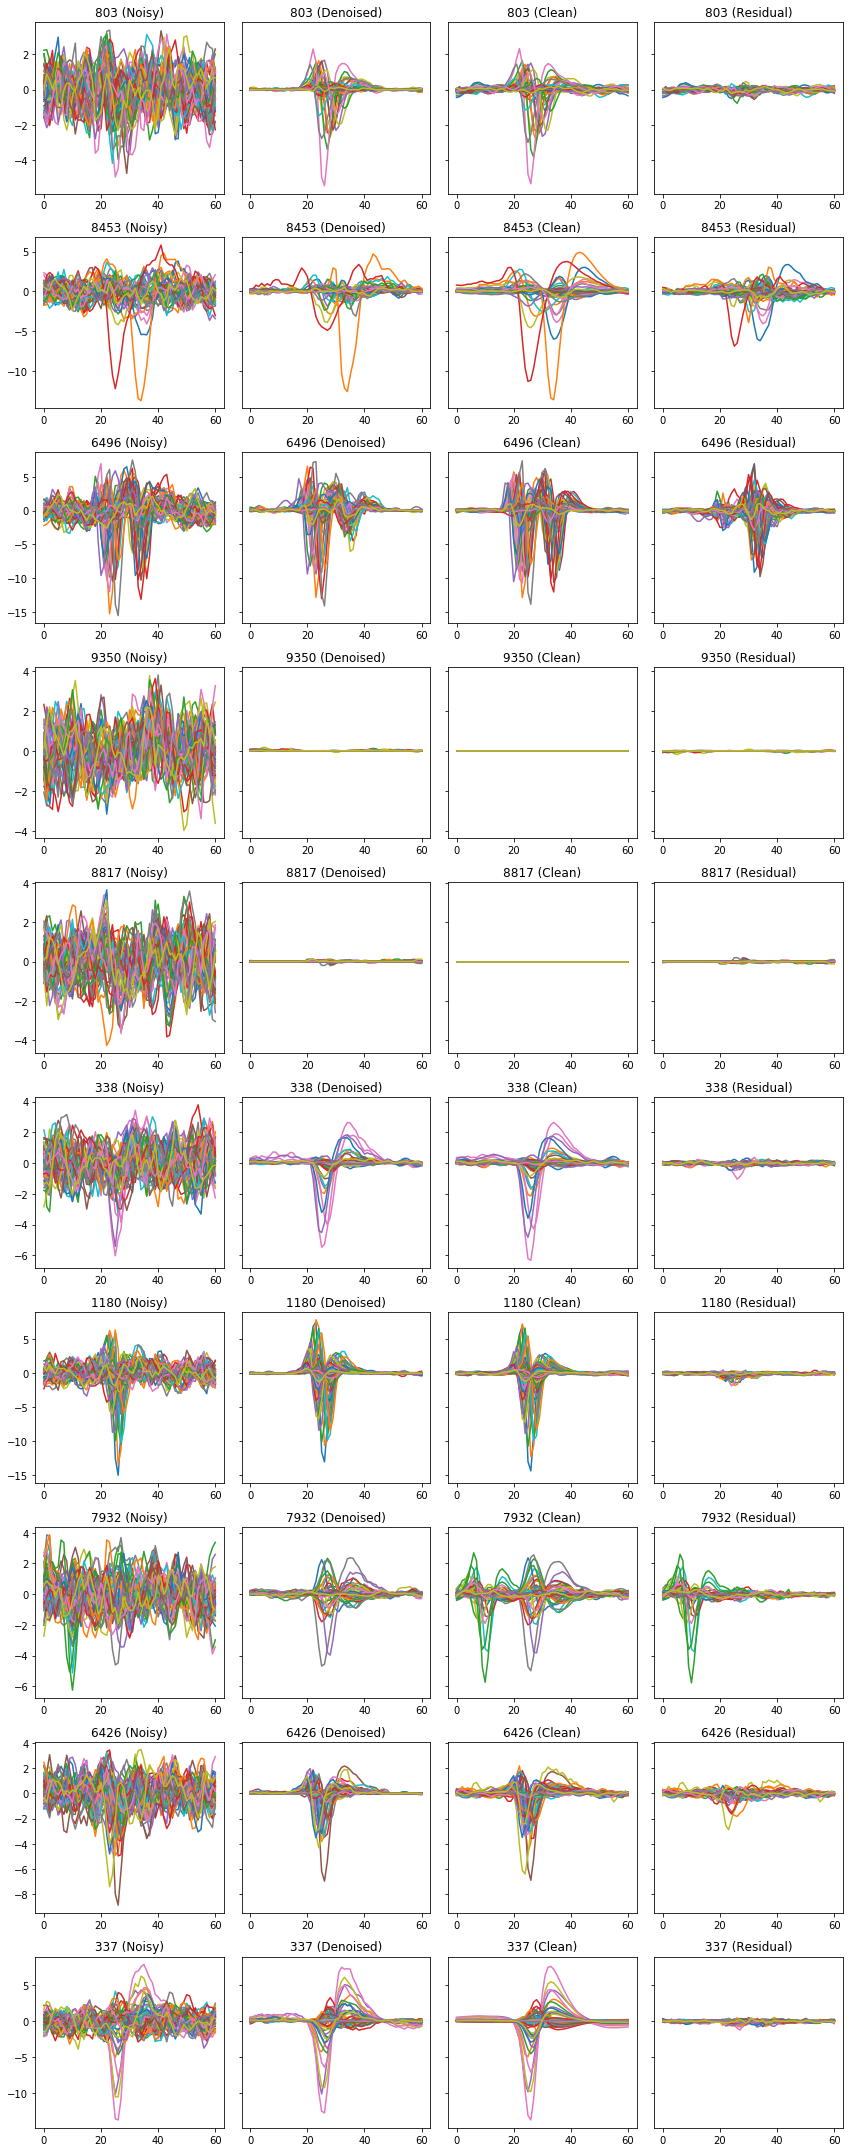

In [59]:
plot.grid_from_array([np.squeeze(x_test_noisy),
                      x_test_denoised,
                      np.squeeze(x_test_clean),
                      residual],
                     axis=0,
                     group_names=('Noisy', 'Denoised', 'Clean', 'Residual'),
                     elements=selected,
                     auto_figsize=3,
                     sharey='row')

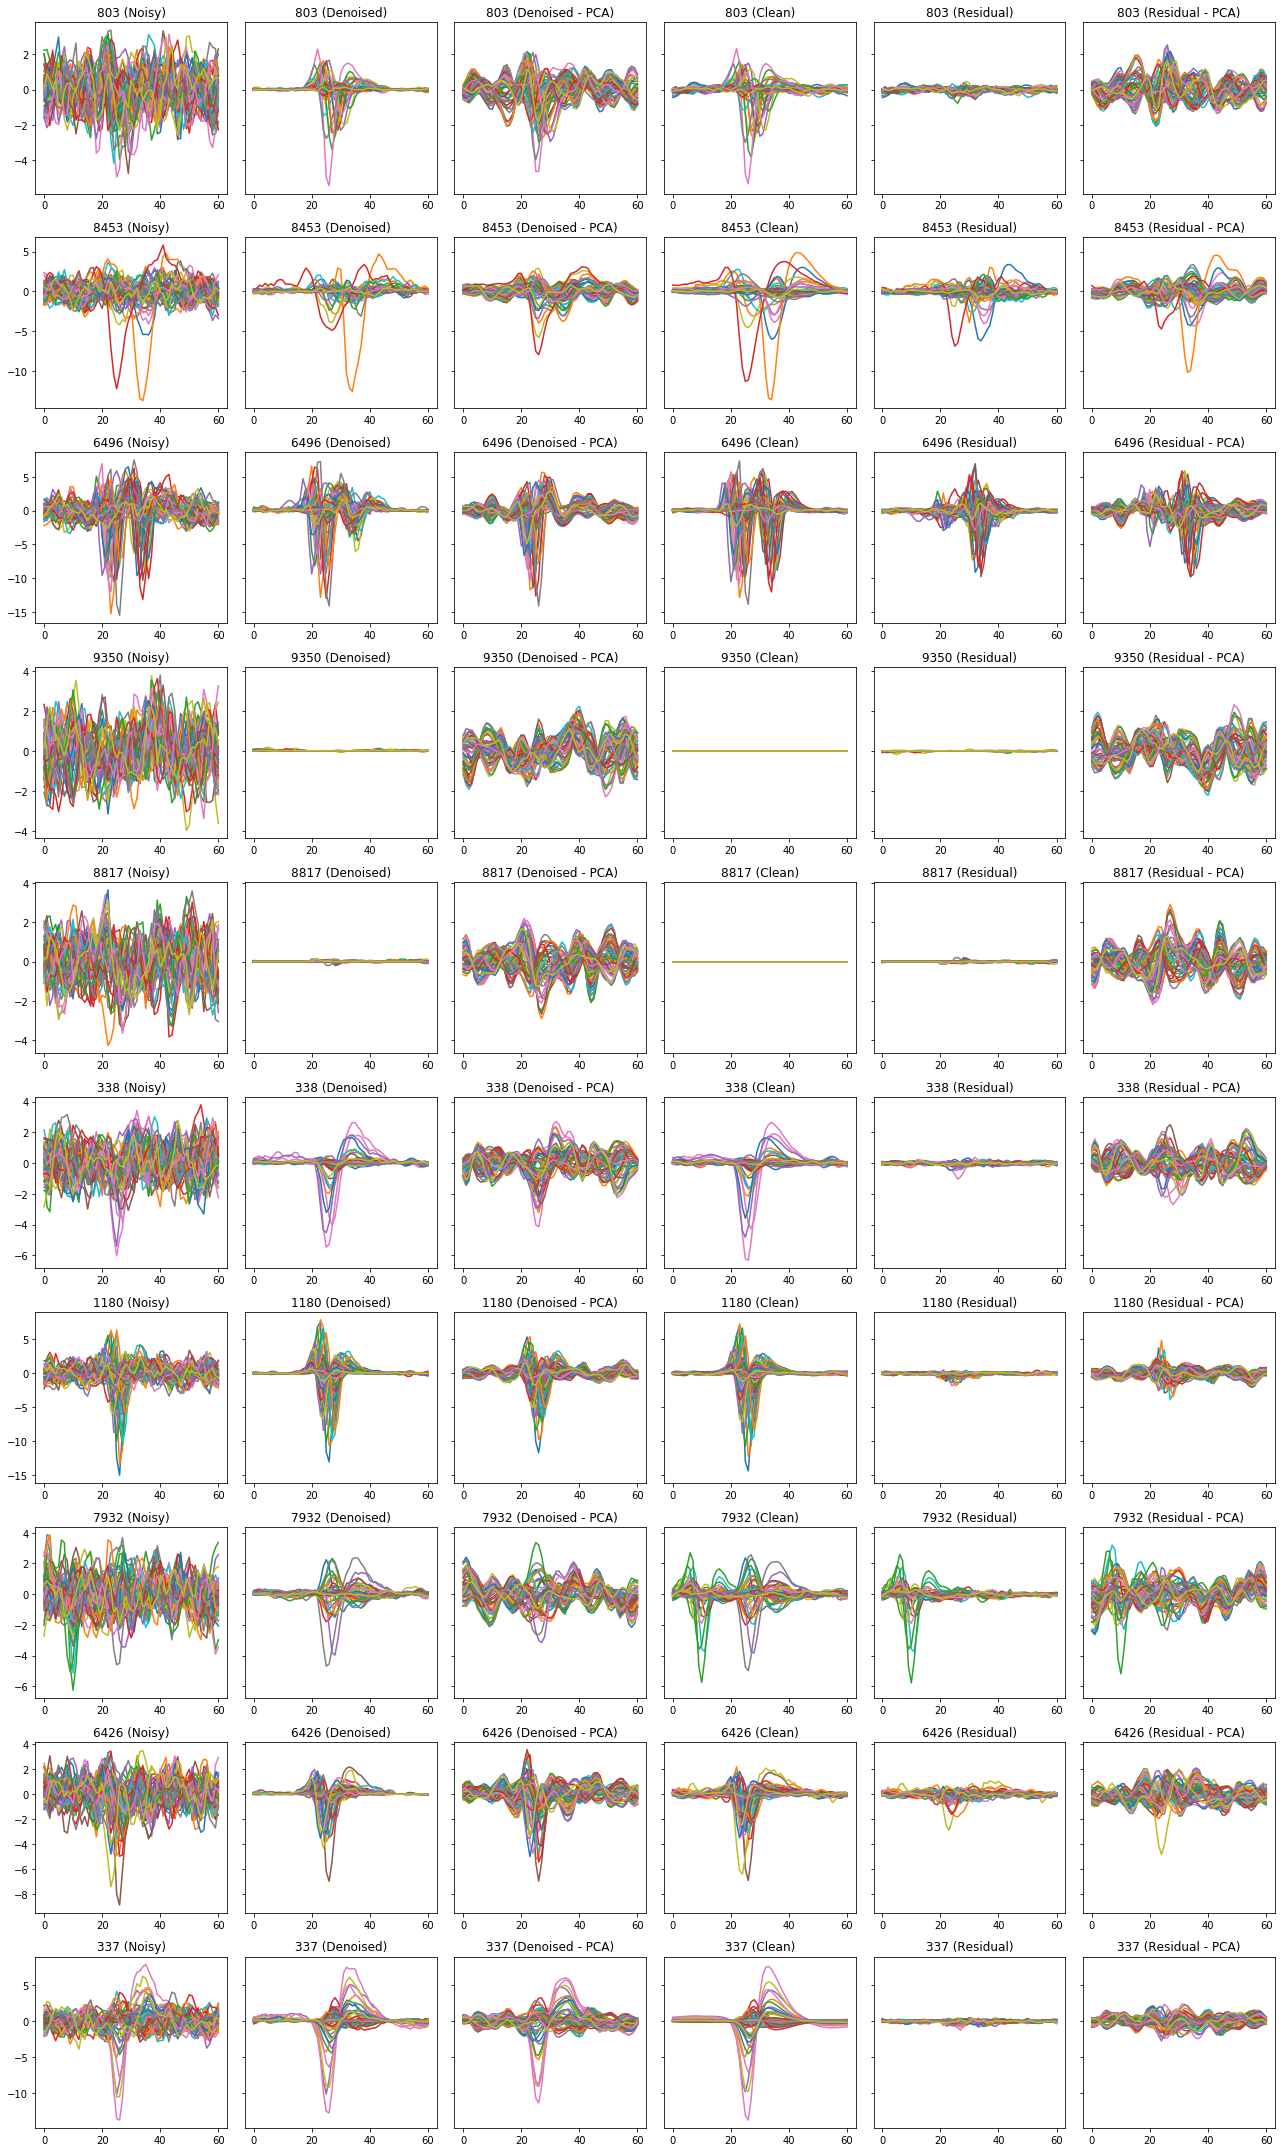

In [60]:
plot.grid_from_array([np.squeeze(x_test_noisy),
                      x_test_denoised,
                      x_test_denoised_pca,
                      np.squeeze(x_test_clean),
                      residual,
                      residual_pca],
                     axis=0,
                     group_names=('Noisy', 'Denoised', 'Denoised - PCA', 'Clean', 'Residual', 'Residual - PCA'),
                     elements=selected,
                     auto_figsize=3,
                     sharey='row')

## Best/worst denoised

In [61]:
errors = np.square(residual ** 2).sum(axis=(1, 2))

In [62]:
errors_sorted_idx = np.argsort(errors)

In [63]:
errors[errors_sorted_idx[:10]]

array([2.19066468e-06, 3.74784224e-06, 9.90698145e-06, 2.09595093e-05,
       2.53162463e-05, 2.79074290e-05, 6.44589402e-05, 7.28509352e-05,
       7.61686786e-05, 7.69074031e-05])

In [64]:
errors[errors_sorted_idx[-10:]]

array([423229.83420648, 425159.76957806, 441961.98720111, 449770.1650141 ,
       458524.4963673 , 474490.69194742, 481278.89611771, 727612.84731108,
       830427.09420818, 870260.50027054])

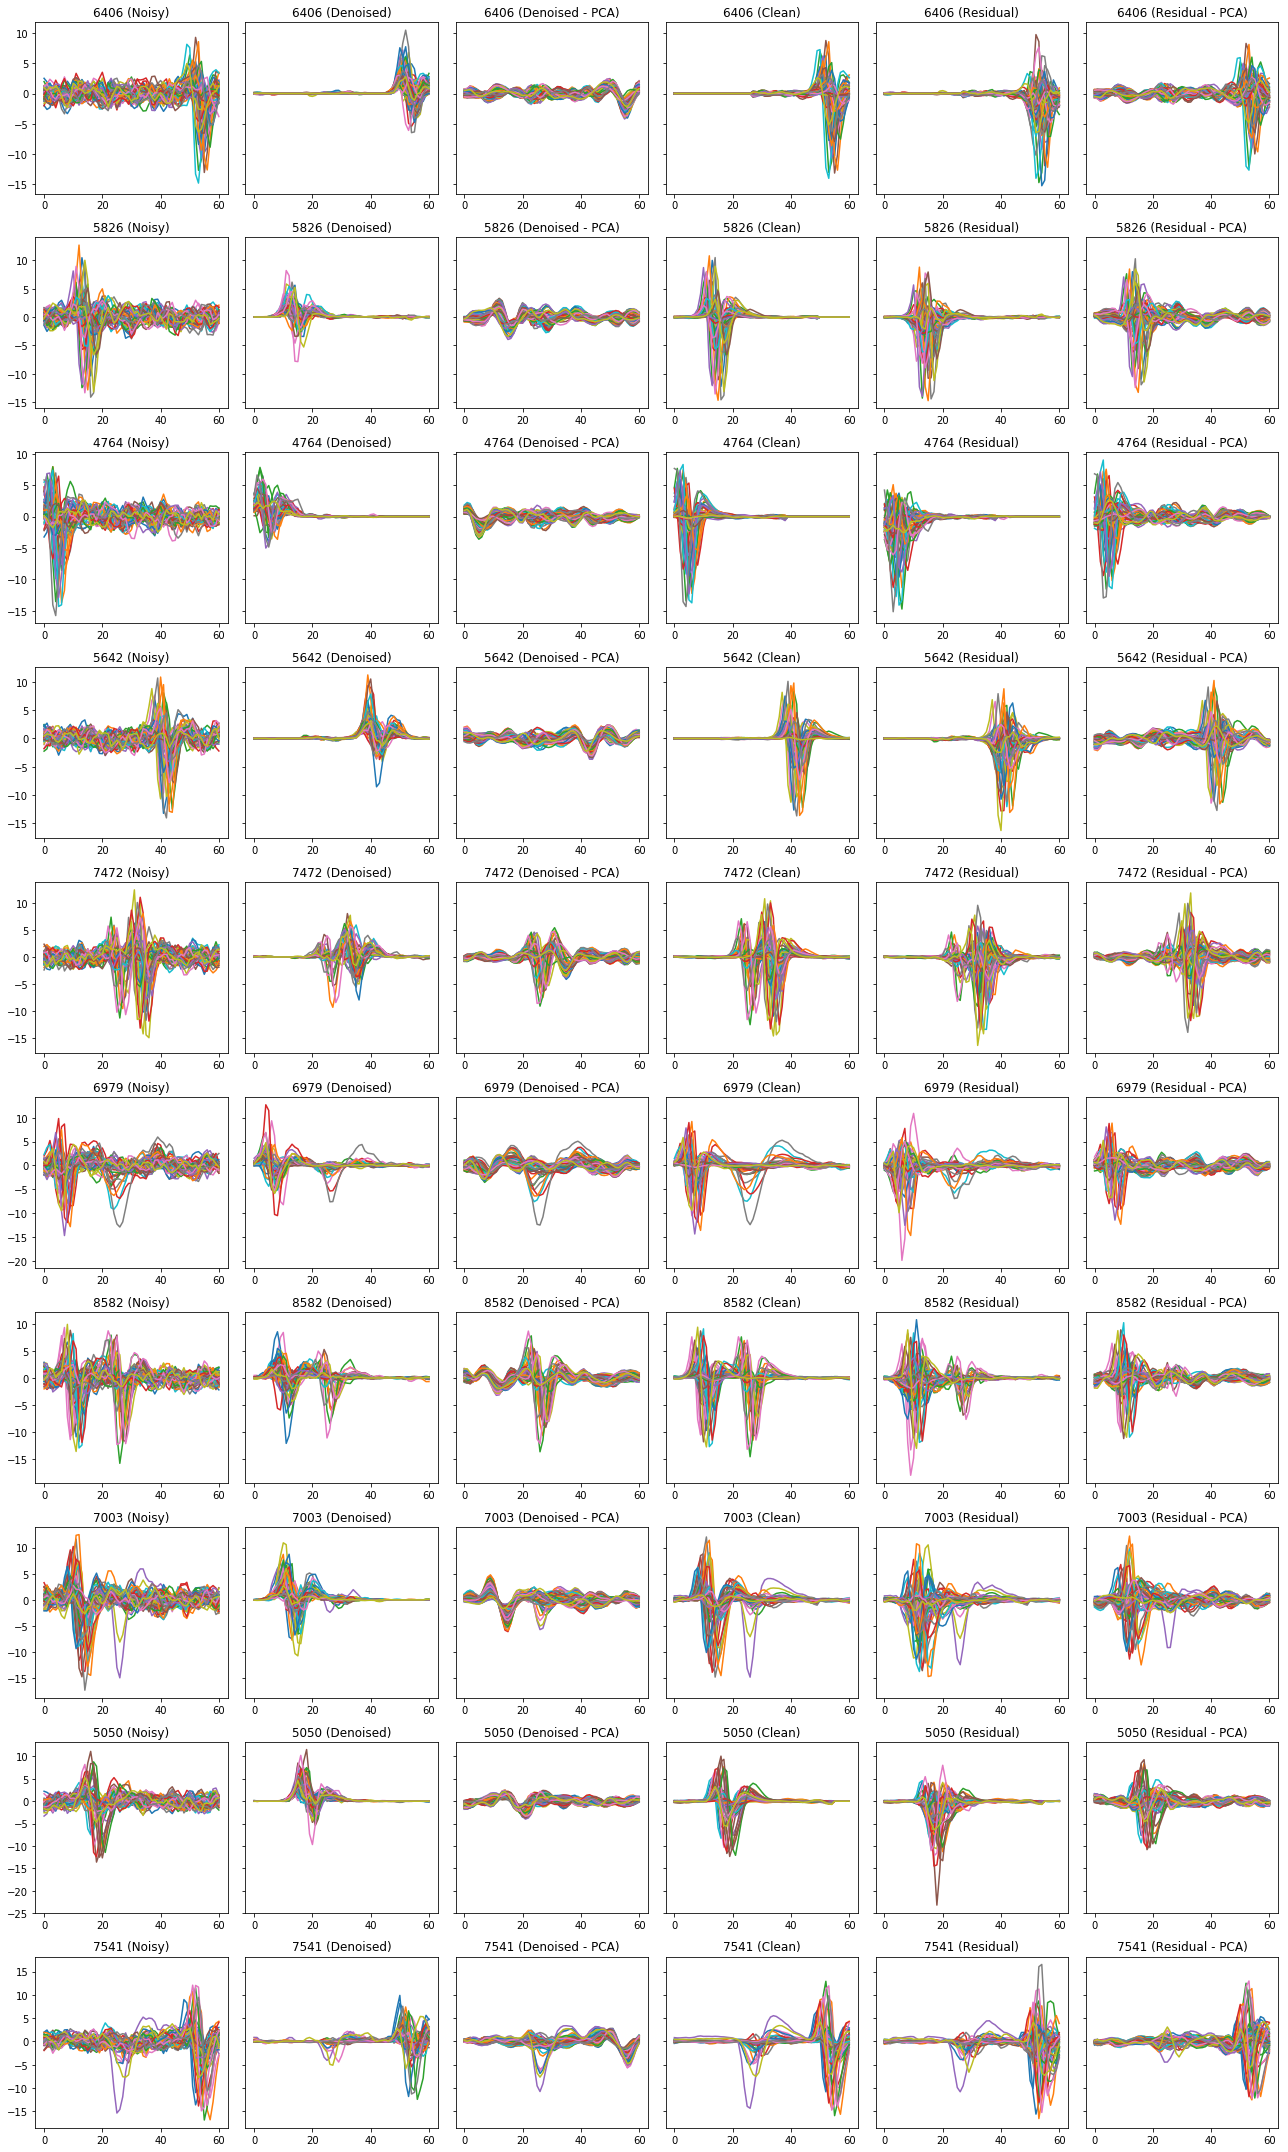

In [65]:
plot.grid_from_array([np.squeeze(x_test_noisy),
                      x_test_denoised,
                      x_test_denoised_pca,
                      np.squeeze(x_test_clean),
                      residual,
                      residual_pca],
                     axis=0,
                     group_names=('Noisy', 'Denoised', 'Denoised - PCA', 'Clean', 'Residual', 'Residual - PCA'),
                     elements=errors_sorted_idx[-10:],
                     auto_figsize=3,
                     sharey='row')

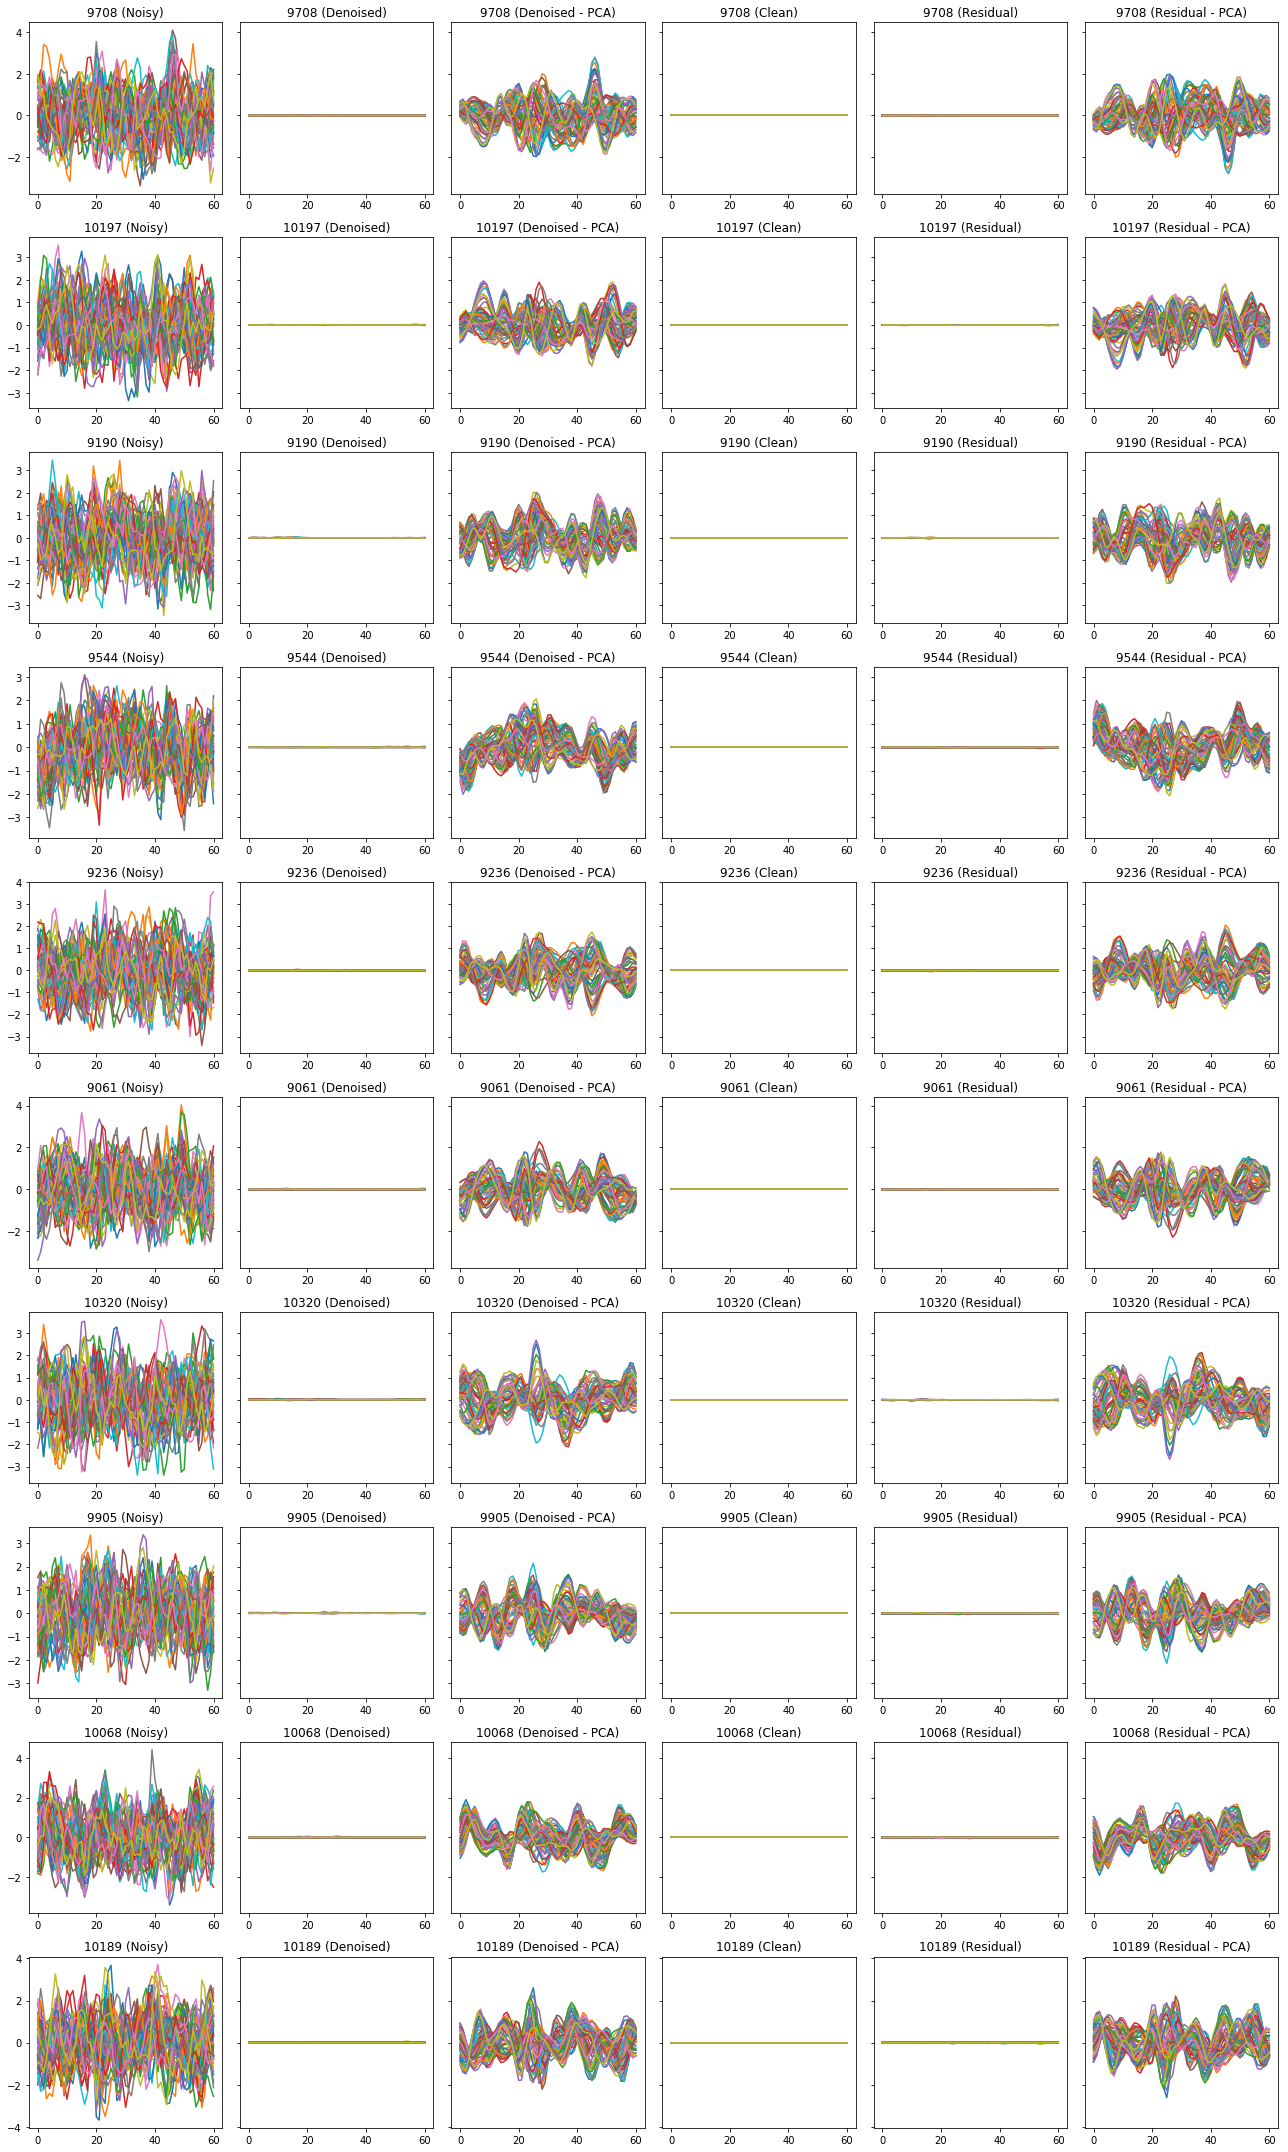

In [66]:
plot.grid_from_array([np.squeeze(x_test_noisy),
                      x_test_denoised,
                      x_test_denoised_pca,
                      np.squeeze(x_test_clean),
                      residual,
                      residual_pca],
                     axis=0,
                     group_names=('Noisy', 'Denoised', 'Denoised - PCA', 'Clean', 'Residual', 'Residual - PCA'),
                     elements=errors_sorted_idx[:10],
                     auto_figsize=3,
                     sharey='row')

In [67]:
def plot_from_indexes(dataset, model, idxs):
    sub_noisy = np.stack(test_set.df_noisy[idxs].waveform.values)
    sub_clean = np.stack(test_set.df_clean[idxs].waveform.values)
    sbu_denoised = predict(model, sub_clean)

    plot.grid_from_array([sub_noisy,
                          sbu_denoised,
                          sub_clean],
                         axis=0,
                         group_names=('Noisy', 'Denoised', 'Clean'),
                         elements=5,
                         figsize=(10, 10),
                         sharey='row')

In [68]:
plot_from_indexes(test_set, autoencoder,
                  test_set.df_noisy.kind == 'zero')

NameError: name 'test_set' is not defined

In [ ]:
plot_from_indexes(test_set, autoencoder,
                  test_set.df_noisy.kind == 'collided')

In [ ]:
plot_from_indexes(test_set, autoencoder,
                  test_set.df_noisy.kind == 'temporally misaligned')

In [ ]:
plot_from_indexes(test_set, autoencoder,
                  test_set.df_noisy.kind == 'spatially misaligned')

In [ ]:
plot_from_indexes(test_set, autoencoder,
                  test_set.df_noisy.kind == 'from templates')

## Denoising (real) patches

## Denoising recordings

In [ ]:
exp = RecordingExplorer(path_to_standarized)

In [ ]:
patch_size = 61
n_patches = 5

In [ ]:
idxs = [(n * patch_size, (n + 1) * patch_size) for n in range(n_patches)]

In [ ]:
# TODO: performance improvement, read a lot of patches and send them to .predict
processed = np.zeros((patch_size * n_patches, 49))

for from_, to_ in idxs:
    patch = exp.reader[from_:to_, :][np.newaxis, :, :, np.newaxis]
    processed[from_:to_, :] = np.squeeze(autoencoder.predict(patch))

In [ ]:
_ = plt.plot(processed)

In [ ]:
_ = plt.plot(exp.reader[:to_])